In [75]:
from easypip import easyimport, easyinstall, is_notebook
easyinstall("bbrl>=0.2.2")
easyinstall("swig")
easyinstall("bbrl_gymnasium>=0.2.0")
easyinstall("bbrl_gymnasium[box2d]")
easyinstall("bbrl_gymnasium[classic_control]")
easyinstall("tensorboard")
easyinstall("moviepy")
easyinstall("box2d-kengz")

[easypip] Installing bbrl_gymnasium>=0.2.0
[easypip] Installing bbrl_gymnasium[box2d]
[easypip] Installing bbrl_gymnasium[classic_control]


In [76]:
import os
import sys
from pathlib import Path
import math
import numpy as np

from moviepy.editor import ipython_display as video_display
import time
from tqdm.auto import tqdm
from typing import Tuple, Optional
from functools import partial

from omegaconf import OmegaConf
import torch
import bbrl_gymnasium

import copy
from abc import abstractmethod, ABC
import torch.nn as nn
import torch.nn.functional as F
from time import strftime

from gymnasium import Env, Space, Wrapper, make

# Imports all the necessary classes and functions from BBRL
from bbrl.agents.agent import Agent
from bbrl import get_arguments, get_class, instantiate_class
# The workspace is the main class in BBRL, this is where all data is collected and stored
from bbrl.workspace import Workspace

# Agents(agent1,agent2,agent3,...) executes the different agents the one after the other
# TemporalAgent(agent) executes an agent over multiple timesteps in the workspace, 
# or until a given condition is reached
from bbrl.agents import Agents, TemporalAgent

# ParallelGymAgent is an agent able to execute a batch of gymnasium environments
# with auto-resetting. These agents produce multiple variables in the workspace:
# ’env/env_obs’, ’env/reward’, ’env/timestep’, ’env/terminated’,
# 'env/truncated', 'env/done', ’env/cumulated_reward’, ... 
# 
# When called at timestep t=0, the environments are automatically reset. At
# timestep t>0, these agents will read the ’action’ variable in the workspace at
# time t − 1
from bbrl.agents.gymnasium import GymAgent, ParallelGymAgent, make_env, record_video

# Replay buffers are useful to store past transitions when training
from bbrl.utils.replay_buffer import ReplayBuffer

import torch.nn as nn

from typing import Tuple
from bbrl.agents.gymnasium import make_env, GymAgent, ParallelGymAgent
from functools import partial

from bbrl import instantiate_class

import matplotlib.pyplot as plt

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

from IPython.display import clear_output

In [77]:
# Utility function for launching tensorboard
# For Colab - otherwise, it is easier and better to launch tensorboard from
# the terminal
def setup_tensorboard(path):
    path = Path(path)
    answer = ""
    if is_notebook():
        if get_ipython().__class__.__module__ == "google.colab._shell":
            answer = "y"
        while answer not in ["y", "n"]:
                answer = input(f"Do you want to launch tensorboard in this notebook [y/n] ").lower()

    if answer == "y":
        get_ipython().run_line_magic("load_ext", "tensorboard")
        get_ipython().run_line_magic("tensorboard", f"--logdir {path.absolute()}")
    else:
        import sys
        import os
        import os.path as osp
        print(f"Launch tensorboard from the shell:\n{osp.dirname(sys.executable)}/tensorboard --logdir={path.absolute()}")

In [78]:
SEED = 42

params={
  "save_best": False,
  "logger":{
    "classname": "bbrl.utils.logger.TFLogger",
    "log_dir": "./tblogs/dqn-buffer-" + str(time.time()),
    "cache_size": 10000,
    "every_n_seconds": 10,
    "verbose": False,    
    },

  "algorithm":{
    "seed": SEED,
    "max_grad_norm": 0.5,
    "epsilon": 0.02,
    "n_envs": 8,
    "n_steps": 32,
    "n_updates": 32,
    "eval_interval": 2000,
    "learning_starts": 2000,
    "nb_evals": 10,
    "buffer_size": 1e6,
    "batch_size": 256,
    "target_critic_update": 5000,
    "max_epochs": 100, #MAX ITER 
    "discount_factor": 0.99,
    "architecture":{"hidden_size": [64, 64]},
  },
  "gym_env":{
    "env_name": "CartPole-v1",
  },
  "optimizer":
  {
    "classname": "torch.optim.Adam",
    "lr": 1e-3,
  }
}

config=OmegaConf.create(params)

In [79]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten
import numpy as np
import random as python_random
import tensorflow as tf


def set_seeds(seed):
    np.random.seed(seed)
    python_random.seed(seed)
    tf.random.set_seed(seed)

class cnnAgent:
    def __init__(self):
        set_seeds(SEED) 

    def build_feature_extractor_model(self, input_shape):
        model = Sequential()
        model.add(Conv2D(32, (7, 7), strides=(2, 2), activation='relu', padding="same", input_shape=(151, 562, 1)))
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Conv2D(64, (7, 7), strides=(2, 2), padding="same", activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Conv2D(64, (7, 7), strides=(2, 2), padding="same", activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Flatten())
        model.add(Dense(100, activation='relu')) #a changer la valeur ici pour la taille du ouput
        return model

    def extract_features(self, image):
        image_resized = np.expand_dims(np.expand_dims(image, axis=-1), axis=0)  
        if not hasattr(self, 'model'):
            self.model = self.build_feature_extractor_model(input_shape=image_resized.shape[1:])
        features = self.model.predict(image_resized)
        return features[0]


In [80]:
from PIL import Image

class preProcessingAgent():
    def __init__(self, parallel_gym_agent):
          self.parallel_gym_agent = parallel_gym_agent

    def preProcess(self, im):
        #plt.imshow(im) #CHANGE HERE TO SEE ORIGINAL FRAME
        #plt.show()
        img = Image.fromarray(im.astype(np.uint8))
        img_gray = img.convert('L')
        img_gray = img_gray.resize((564, 152)) #a modifier peut etre im.shape[1], im.shape[0])
        img_array = np.array(img_gray)

        return img_array

    def crop(self, im):
        im = Image.fromarray(im.astype(np.uint8))
        width, height = im.size
    
        new_width, new_height = 300, 300  # New dimensions for the crop
        left = (width - new_width)/8
        top = (height - new_height)/0.6
        right = (width + new_width)/1.5
        bottom = (height + new_height)/2.2
        
        im1 = im.crop((left, top, right, bottom))
        img_array = np.array(im1)
        return img_array

    def getFrame(self, env_agent):
        env: Env = env_agent.envs[0]
        env.reset()
        im = env.render()
        im = self.crop(im)
        im = self.preProcess(im)
        return im


TEST AVEC UN RANDOM AGENT

In [81]:
class RandomAgent(Agent):
    def __init__(self, action_dim):
        super().__init__()
        self.action_dim = action_dim
        self.all_observations = []

    def forward(self, t: int, choose_action=True, **kwargs):
        """An Agent can use self.workspace"""
        obs = self.get(("env/env_obs", t))
        action = torch.randint(0, self.action_dim, (len(obs), ))
        self.set(("action", t), action)
        self.all_observations.append(obs)


In [82]:
class StateCaptureAgent(Agent):
    def __init__(self, storage_list):
        super().__init__()
        self.storage_list = storage_list  # This list will store the states

    def forward(self, t: int, **kwargs):
        # Retrieve the current state (observation) from the workspace
        current_state = self.get(("env/env_obs", t))
        # Append the current state to the storage list
        self.storage_list.append(current_state)
        

In [83]:
class CustomParallelGymAgent(ParallelGymAgent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def get_my_attribute(self):
        # Replace 'my_attribute' with the actual attribute you're interested in
        return self.envs

In [90]:
class AttributeAccessAgent(Agent):
    def __init__(self, env_agent, list_images):
        super().__init__()
        self.env_agent = env_agent  # CustomParallelGymAgent ou ParallelGymAgent
        #init de la liste de listes pour store les images
        self.list_images = [[] for _ in range(self.env_agent.num_envs)]
    
    def forward(self, t: int, **kwargs):
        for env_index in range(self.env_agent.num_envs):
            # Assuming your env_agent can provide access to each environment's render method
            image = self.env_agent.envs[env_index].render()
            display = False
            if display: #print a chaque temps
                clear_output(wait=True)  # pour print live mais pas utile pour +1 env
                plt.imshow(image)  
                plt.axis('off')
                plt.show()
                print("Displayed image at time", t, " of agent ", env_index)
            #print(image.shape)

            # Append the image to the corresponding list
            self.list_images[env_index].append(image)

#Du coup pour recuperer les images a chaque nouveau temps 
#il faut acceder a la derniere image ajoutee dans list_images 
#et la passer dans le cnn

In [85]:
def displayImagesPerAgent(images_per_agent, nb_env):
    n_cols = 3  # Number of columns in the grid
    
    for env_index, images in enumerate(images_per_agent):
        print(f"Environment {env_index + 1}:")
        n_images = len(images)
        n_rows = (n_images + n_cols - 1) // n_cols  # Rows per environment

        figsize_width = 8  # Adjust width as needed
        figsize_height = n_rows * (figsize_width / n_cols) * 0.5  # Adjust height based on number of rows, keeping aspect ratio
        plt.figure(figsize=(figsize_width, figsize_height))

        for i, image in enumerate(images):
            plt.subplot(n_rows, n_cols, i+1)
            plt.imshow(image)
            plt.axis('off')  # Optional: to hide axes
        
        plt.tight_layout()
        plt.show()

(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
Donzo got all images
Environment 1:


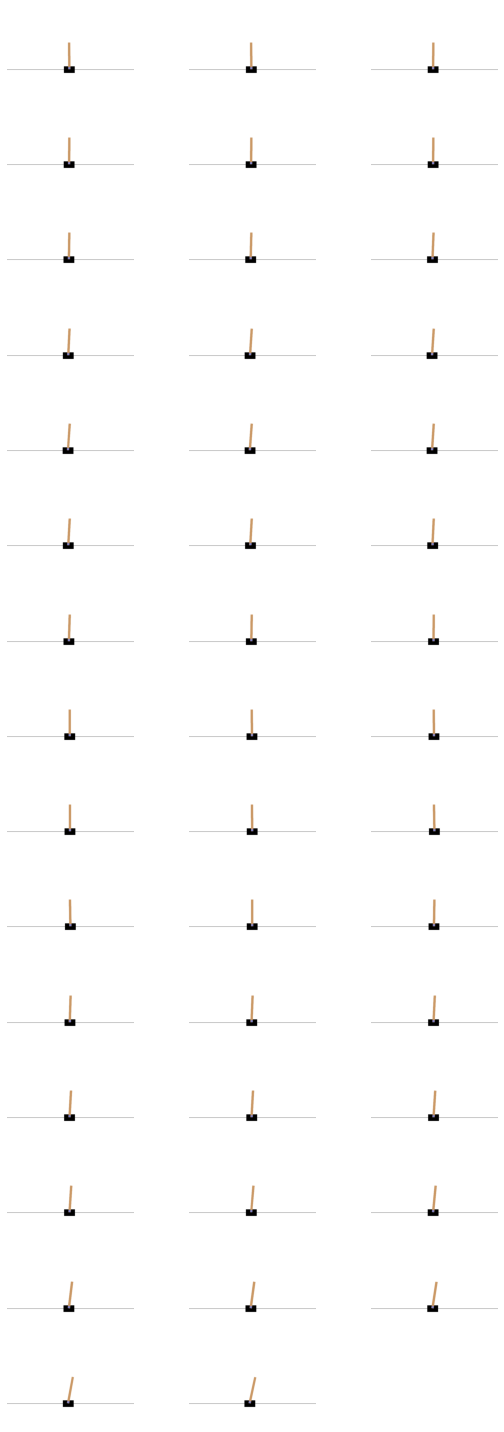

In [92]:
nb_env = 1
action_dim = 2 #vaudrait mieux prednre depuis le parallelgymagent mais ca va jamais changer ici
#autoreset = False pour le moment pouor le simplifier la vie
im_env_agent = CustomParallelGymAgent(partial(make_env, config.gym_env.env_name, render_mode="rgb_array", autoreset=False), nb_env).seed(SEED)
attribute_access_agent = AttributeAccessAgent(im_env_agent, [])
agents = Agents(im_env_agent, RandomAgent(action_dim), attribute_access_agent)
t_agents = TemporalAgent(agents)
workspace = Workspace()
t_agents(workspace, t=0, stop_variable="env/done", stochastic=True)
images = attribute_access_agent.list_images #bon seul soucis c'est qu'on recupere les images apres coup
print('Donzo got all images')


displayImagesPerAgent(images, nb_env)

OK ON VA ESSAYER DE FAIRE UN AGENT DQN MAINTENANT